# **Neural Prophet Parameters**
### ******Input Parameters from Interface******

In [1]:
#NeuralProphet

#Excel file Path
file_path= '/home/ajaz/DemandForecasting/Data/sampledata.csv'    
 
#1. **Growth Parameters:**
detectGrowth=True #bool
growth='off'  #Literal['off', 'linear', 'discontinuous']

#2. **Changepoints Parameters:**
detectChangepoints=True #bool
changepoints= None #Optional[list]
n_changepoints =None    #0, #int
changepoints_range=None     #0.8 #float

#3. **Seasonality Parameters:**
#To Control Seasonality
yearly_seasonality= None  #'auto'ss
weekly_seasonality= None   #'auto'
daily_seasonality = None   #'auto'

seasonality_mode='multiplicative' #['additive', 'multiplicative']
seasonality_reg= None    #float 0

#4. **Confidence Interval Parameters:**
confidence_lv = 0.9
#quantiles  = None      #[]   #List[float]
quantiles = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)]

#5. **Missing Data Handling:**
impute_missing= None,     #bool
impute_linear = None,    #int
impute_rolling= None,  #int
drop_missing  = None   #bool

#6. **Normalization Parameters:**
normalize=None         #'off'     # Literal['auto', 'soft', 'soft1', 'minmax', 'standardize', 'off']

#7. **Lags and Forecasts:**
n_lags=None        #0    # int 0    
n_forecasts=None   #0 #int 1

#8. **Autoregression Parameters:**  
ar_layers=None     #[]    #Optional[list]   
ar_reg= None       #Optional[float]     
lagged_reg_layers= None    #[]   #Optional[list]       
learning_rate= 0.1   #Optional[float]

#9. **Training Parameters:**
epochs= None      #Optional[int]
batch_size= None   #Optional[int]
loss_func=None     #'Huber'
optimizer=None     #'AdamW'

#10. **Global/Local Parameters:**
season_global_local=None #['global', 'local']
trend_global_local= None   #str 'global', 'local'

#11. **Trend Parameters:**
trend_reg= None  #Optional[float]
trend_reg_threshold =None  #Optional[Union[bool, float]]
newer_samples_weight= None  # float
newer_samples_start =None   #float

#12. **Additional Configuration:**
collect_metrics= None      #Union [bool, list, dict]

global_normalization=None
global_time_normalization=None
unknown_data_normalization=None

accelerator=None  #Optional[str] None
trainer_config=None # dict {},
prediction_frequency=None  # Optional[dict]

In [2]:
#Additional  Seasonality regressors

#Custom holidays
country_name= 'SA'   #   'SA' # Country Code  (ISO 3166-2) for holidayss

yearly_add_seasonality=True
yearly_season_period=365.25
yearly_season_fourier_order=2

quarterly_add_seasonality=False
quarterly_season_period=None
quarterly_season_fourier_order=None

monthly_add_seasonality=False
monthly_season_period=None
monthly_season_fourier_order=None

# Weekend days (0-6, Mon-Sun)
weekend_days = [4]  # 4 is Friday

Weekend_add_seasonality=False
weekendDaysCount=1
Weekends_fourier_order=5

WorkingDays_add_seasonality=False
workingDaysCount=6
WorkingDays_fourier_order=5

ramadan_add_seasonality=False
ramadan_period=29.33
ramadan_fourier_order=10

#### ******Parameters used in other calc, other than the model******


In [3]:
# Penalty sensitivity for PELT algorithm: 'High', 'Medium', 'Low' : Used to determine the penalty value for the PELT algo which is used for changepoint detection
PenaltySensitivity ="High"  

# Model type for changepoint detection: 'l1' (linear 1), 'l2' (linear 2), 'rbf' (radial basis function)
pltModelType = "l2"  # "l2", "rbf"

detectOutliers =False # If True, outliers are detected and removed from the data else outliers are not detected and not removed from the data

#IQR stands for Interquartile Range, which is a measure of statistical dispersion of data
#IQR Range for outlier detection (1.5 is default) 3 is too high ,  upper_bound = Q3 + IQRRange * IQR and lower_bound = Q1 - IQRRange * IQR 

IQRRange=1.5

# ****Prophet Algorithm****

### ****Importing Libraries****

In [4]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd

import matplotlib.pyplot as plt

import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation

#import myModule as myModule
from myModule.fileIO import loadCsvExcelFile 
from myModule.dataAnalysis import detectGrowth 

from myModule.dataAnalysis import detectChangepoints
from myModule.dataAnalysis import detectOutliers
from myModule.dateGeneration import generateRamadanDates
from myModule.dateGeneration import generateWeekends

warnings.filterwarnings("ignore")

Initializing myModule package


### ****Importing the dataset****

##### Importing Data using the Function

In [5]:
file_path = "/home/ajaz/DemandForecasting/Data/sampledata.csv"

#Load Data 
data = loadCsvExcelFile(file_path)

data['date'] = pd.to_datetime(data['date'])
data.rename(columns={'date':'ds','value':'y'},inplace=True)
# Get the first and last dates of the filtered data
startDate = pd.to_datetime( data['ds'].iloc[0])
endDate = pd.to_datetime( data['ds'].iloc[-1])

startYear = startDate.year
endYear = endDate.year

data.head()

,ds,y
0,2018-01-01,50930.49
1,2018-01-02,73204.65
2,2018-01-03,60450.73
3,2018-01-04,101558.60
4,2018-01-05,0.00


In [6]:
#Growth Detection
if detectGrowth:
    growth = detectGrowth(data)
    print("Growth Detected : ",growth)
else:
    print("Manual, Growth Detection is Off")

Growth Detected :  linear


In [7]:
#detect Change points
if detectChangepoints:
    changepoints= detectChangepoints(data, pltModelType, PenaltySensitivity)
    print("Sucessfully detected Change points")
    #print("Change points : ",changepoints)
else:
    print("Manual, Change points Detection is Off")

Sucessfully detected Change points


In [8]:
#detect Outliers
if detectOutliers:
    lower_bound, upper_bound = detectOutliers(data, IQRRange)
    outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]
    data.loc[outliers.index, 'y'] = data['y'].mean()
    print("Sucessfully Removed the Outliers")
print("Outlier Detection  is disabled")

count      2038.000000
mean      66087.199681
std       59231.218862
min           0.000000
25%       13084.537500
50%       52054.130000
75%      110176.500000
max      347483.000000
Name: y, dtype: float64
Sucessfully Removed the Outliers
Outlier Detection  is disabled


In [9]:
#Add Ramadan Seasonality

if ramadan_add_seasonality:
    ramadan_df = generateRamadanDates(startYear, endYear)
    data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
    print("Sucessfully Added Ramadan dates in prophet Training Data")
    print(data)
else:
    print("Ramadan Seasonality is disabled")

Ramadan Seasonality is disabled


In [10]:
#Variables for Weekend and Working days must be imported from input parameters
startDate = '2018-01-01'
endDate = '2023-07-31'
weekendDays = [4]  # 4 is Friday

if Weekend_add_seasonality:
    df_weekends = generateWeekends(startDate, endDate, *weekendDays)
    data['is_weekend'] = data['ds'].isin(df_weekends['ds']).astype(int)  
    print("Sucessfully Added Weekend dates in prophet Training Data")
else:
    print("Weekend Seasonality is disabled")

if WorkingDays_add_seasonality:
    data['is_weekday'] = (data['is_weekend'] == 0).astype(int)
    print("Sucessfully Added Working days in prophet Training Data")
else:
    print("Working days Seasonality is disabled")

Weekend Seasonality is disabled
Working days Seasonality is disabled


# Create a Prophet model with flexible parameters

In [11]:
neuralprophet_params = {
'growth':growth,
'changepoints':changepoints,
'n_changepoints':n_changepoints,
'changepoints_range':changepoints_range,

'yearly_seasonality':yearly_seasonality,
'weekly_seasonality':weekly_seasonality,
'daily_seasonality':daily_seasonality,

'seasonality_mode':seasonality_mode,
'seasonality_reg':seasonality_reg,

'quantiles':quantiles,

'impute_missing':impute_missing,
'impute_linear':impute_linear,
'impute_rolling':impute_rolling,
'drop_missing':drop_missing,
'normalize':normalize,

'n_lags':n_lags,
'n_forecasts':n_forecasts,

'ar_layers':ar_layers,
'ar_reg':ar_reg,
'lagged_reg_layers':lagged_reg_layers,
'learning_rate':learning_rate,

'epochs':epochs,
'batch_size':batch_size,
'loss_func':loss_func,
'optimizer':optimizer,

'season_global_local':season_global_local,

'trend_reg':trend_reg,
'trend_reg_threshold':trend_reg_threshold,
'trend_global_local':trend_global_local,

'newer_samples_weight':newer_samples_weight,
'newer_samples_start':newer_samples_start,

'collect_metrics':collect_metrics,

'global_normalization':global_normalization,
'global_time_normalization':global_time_normalization,
'unknown_data_normalization':unknown_data_normalization,

'accelerator':accelerator,
'trainer_config':trainer_config,
'prediction_frequency':prediction_frequency

}
print(neuralprophet_params)
# Remove parameters with value None
neuralprophet_params = {key: value for key, value in neuralprophet_params.items() if value is not None}
print(neuralprophet_params)

{'growth': 'linear', 'changepoints': 0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
1981   2023-07-27
1982   2023-07-28
1983   2023-07-29
1984   2023-07-30
1985   2023-07-31
Name: ds, Length: 1986, dtype: datetime64[ns], 'n_changepoints': None, 'changepoints_range': None, 'yearly_seasonality': None, 'weekly_seasonality': None, 'daily_seasonality': None, 'seasonality_mode': 'multiplicative', 'seasonality_reg': None, 'quantiles': [0.05, 0.95], 'impute_missing': (None,), 'impute_linear': (None,), 'impute_rolling': (None,), 'drop_missing': None, 'normalize': None, 'n_lags': None, 'n_forecasts': None, 'ar_layers': None, 'ar_reg': None, 'lagged_reg_layers': None, 'learning_rate': 0.1, 'epochs': None, 'batch_size': None, 'loss_func': None, 'optimizer': None, 'season_global_local': None, 'trend_reg': None, 'trend_reg_threshold': None, 'trend_global_local': None, 'newer_samples_weight': None, 'newer_samples_start': None, 'collect_metr

# **Training Model**

#### ****Initialize the Model**** ####

In [12]:
print(neuralprophet_params)

{'growth': 'linear', 'changepoints': 0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
1981   2023-07-27
1982   2023-07-28
1983   2023-07-29
1984   2023-07-30
1985   2023-07-31
Name: ds, Length: 1986, dtype: datetime64[ns], 'seasonality_mode': 'multiplicative', 'quantiles': [0.05, 0.95], 'impute_missing': (None,), 'impute_linear': (None,), 'impute_rolling': (None,), 'learning_rate': 0.1}


In [13]:
model = NeuralProphet (**neuralprophet_params)

In [14]:
data.head(2)

,ds,y
0,2018-01-01,50930.49
1,2018-01-02,73204.65


### ****Custom  Seasonalties****

In [15]:
#Custom seasonality
#if the  passed condition is True or Not none then it  execute the below code
#Check the names of the variables from the variables

if country_name:
    model.add_country_holidays(country_name=country_name)

if yearly_add_seasonality:
    model.add_seasonality(name='yearly_season' ,period=yearly_season_period ,fourier_order=yearly_season_fourier_order )

if quarterly_add_seasonality:
    model.add_seasonality(name='quarterly_season' ,period=quarterly_season_period ,fourier_order=quarterly_season_fourier_order )

if monthly_add_seasonality:
    model.add_seasonality(name='monthly_season' ,period=monthly_season_period ,fourier_order=monthly_season_fourier_order )

if Weekend_add_seasonality:
    model.add_seasonality(name='Weekends_season' ,period=weekendDaysCount ,fourier_order=Weekends_fourier_order ,condition_name="is_weekend")

if WorkingDays_add_seasonality:
    model.add_seasonality(name='WorkingDays_season' ,period=workingDaysCount ,fourier_order=WorkingDays_fourier_order ,condition_name="is_weekday")

if ramadan_add_seasonality:
    model.add_seasonality(name='ramadan_season' ,period=ramadan_period ,fourier_order=ramadan_fourier_order ,condition_name="is_ramadan")

#### ****Fit the model to the data**** ####

In [16]:
# Use static plotly in notebooks
model.set_plotting_backend("plotly-static")
model.fit(data)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.951% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 157


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,115405.562500,135335.421875,0.829576,0.0,0
1,57605.027344,71934.062500,0.214509,0.0,1
2,45018.976562,56221.574219,0.152137,0.0,2
3,37251.203125,49851.449219,0.124613,0.0,3
4,35400.496094,45212.664062,0.108383,0.0,4
...,...,...,...,...,...
152,21998.369141,31012.046875,0.046489,0.0,152
153,21992.119141,30962.472656,0.046401,0.0,153
154,21940.558594,31041.162109,0.046474,0.0,154
155,22016.746094,30802.568359,0.046469,0.0,155


## Generate future Dataframe Dates

In [17]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = model.make_future_dataframe(data, n_historic_predictions=True, periods=30)
 # Predict the future
forecast = model.predict(df_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.951% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.952% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.952% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 30 rows at the end with NaNs in 'y' column.


Predicting: 32it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


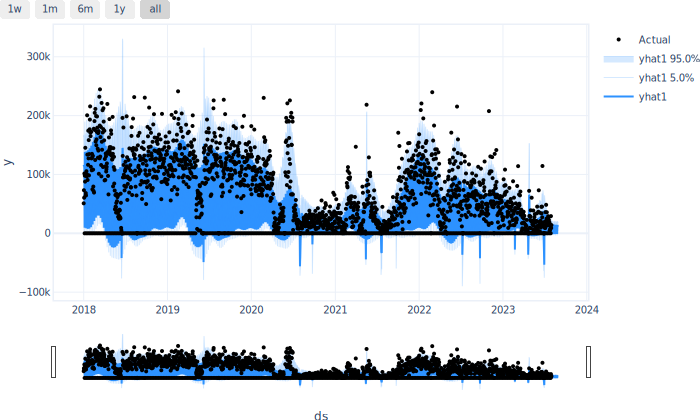

In [18]:
# Visualize the forecast
model.plot(forecast)

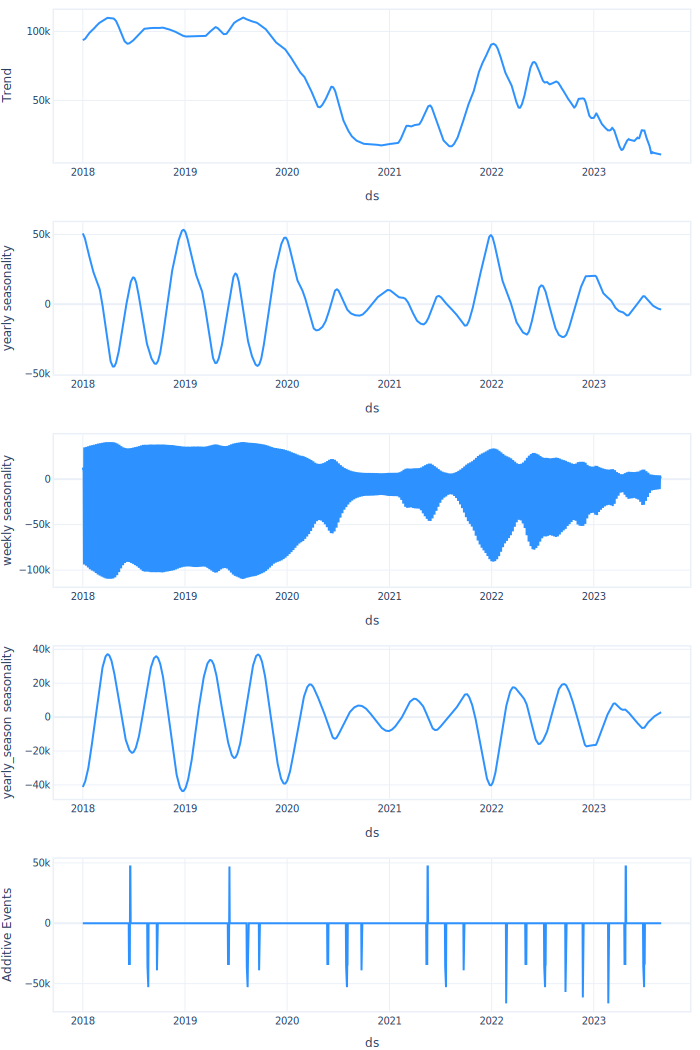

In [19]:
model.plot_components(forecast)

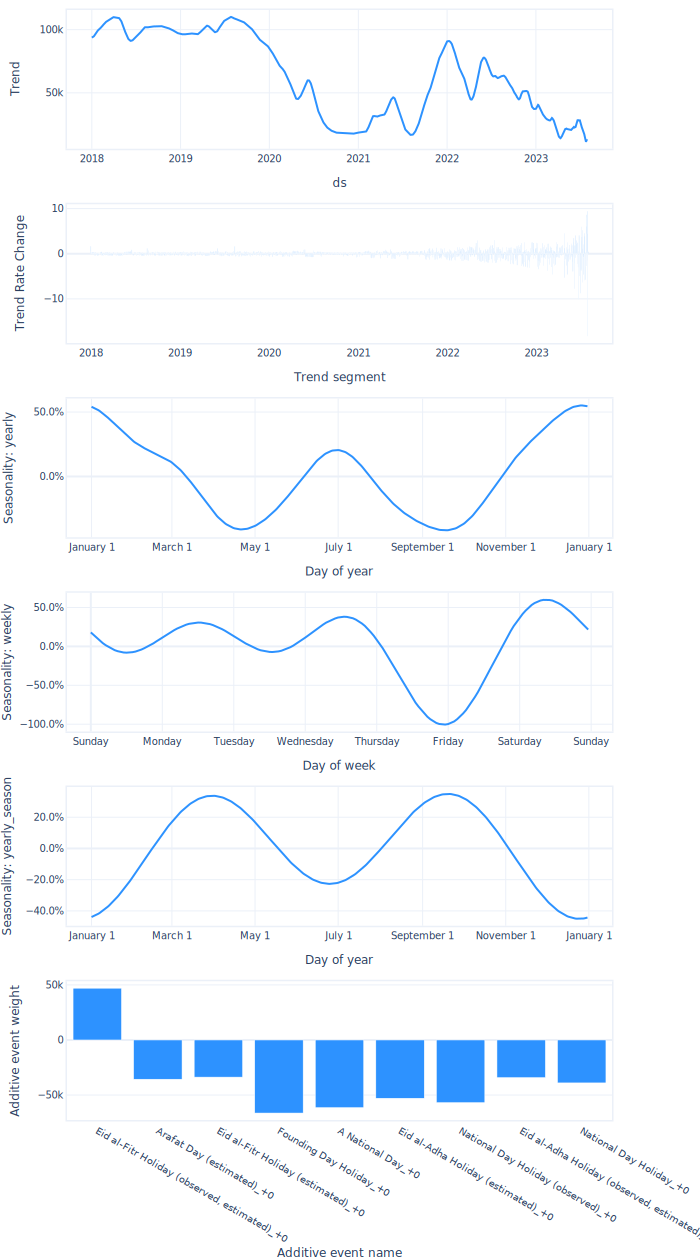

In [20]:
model.plot_parameters()

In [21]:
model.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


In [22]:
#last 30 days of the forecast
forecast.tail(2)

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly,season_weekly,season_yearly_season,events_additive,event_A National Day,event_Arafat Day (estimated),event_Eid al-Adha Holiday (estimated),"event_Eid al-Adha Holiday (observed, estimated)",event_Eid al-Fitr Holiday (estimated),"event_Eid al-Fitr Holiday (observed, estimated)",event_Founding Day Holiday,event_National Day Holiday,event_National Day Holiday (observed)
2066,2023-08-29,NaN,11276.273438,4841.864746,18354.681641,10828.288086,-3790.325195,1433.985352,2804.325928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2067,2023-08-30,NaN,11033.835938,4610.670410,17801.037109,10783.006836,-3834.938965,1212.361572,2873.407227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparision of actual data and forecasted data

In [23]:
actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')

In [24]:
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
#Convert a dataframe column to date only
actualdata['ds']=pd.to_datetime(actualdata['ds']) 
forecast = forecast[['ds','yhat1']].tail(30)

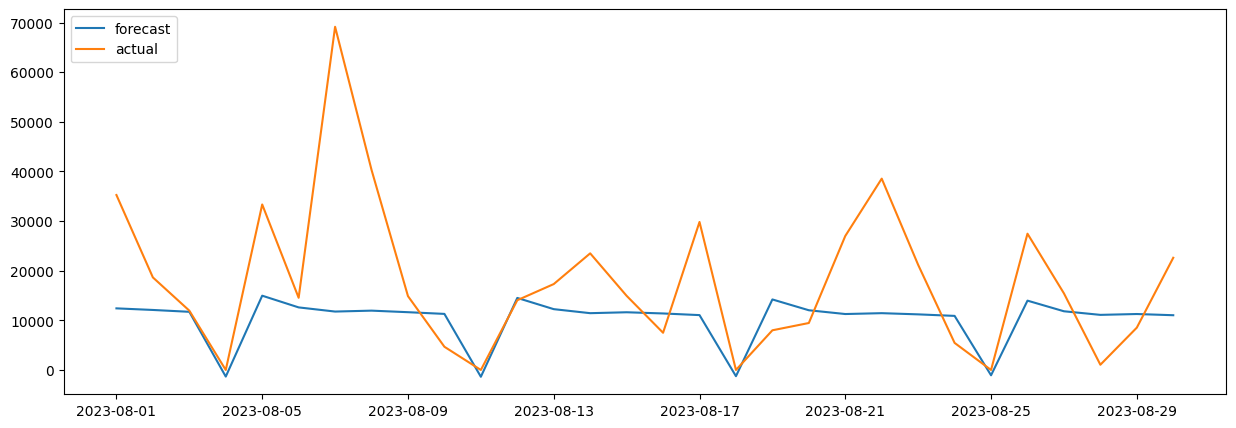

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(forecast['ds'], forecast['yhat1'], label='forecast')
ax.plot(actualdata['ds'], actualdata['actual'], label='actual')
ax.legend(loc='upper left')

plt.show()

## Validation and Reproducibility

In [26]:
df = data.copy()
df_train, df_test = model.split_df(df=df, freq="D", valid_p=0.2)
# Split the dataset into training and validation sets
forecast_test = model.predict(df=df_test)
metrics_test = model.test(df=df_test)
metrics_test[['MAE_val']]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.951% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.754% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.754% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 32it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.754% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03584352880716324
         MAE_val               15339.8046875
        RMSE_val              22302.314453125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val
0,15339.804688
